# Symmetry related computation to get auxilary data and to test symmetrization features for MCMR 

In [1]:
import meshzoo
import numpy as np
import igl
import meshplot as mp
import scipy.io
import os
import math
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, display, Markdown
import ipywidgets as widgets
from meshplot_utils import add_transparent_mesh, color4plot, DrawMeshes, Out, reflectX
#from utils.debug_utils import picture_table_with_title
import utils.debug_utils  as du
import glob
import fnmatch
import  utils.geometry as gu
from auxilary.test_postprocessing import get_obj_files, get_obj_class_by_index


In [2]:
#configurations 
shading_dic = dict(wireframe=True, line_color= [0.2,0.2,0.2] )
resolutions= [2,3,4]

npy_file     = '../auxilary/icoshpere_meshes.npy'
npy_sub_file = '../auxilary/icoshpere_mesh_subdivision_1.npy'


# #========================== small scale tests 10% ==================================
# data_path_list = ['../save/car_10_MRCNN_small/car_small-qualitative',\
#                   '../save/plane_car_1_PointRend_small/aeroplane_small-car_small-qualitative',\
#                   '../save/plane_car_2_PointRend_small/aeroplane_small-car_small-qualitative', \
#                   '../save/bicycle_bus_car_bike_1_PointRend_small/bicycle_small-bus_small-car_small-motorbike_small-qualitative',\
#                   '../save/bicycle_bus_car_bike_4_PointRend_small/bicycle_small-bus_small-car_small-motorbike_small-qualitative' \
#                 ] 


#=============================full test datas ======================================
data_path_list = ['../save/car_10_MRCNN__/car-qualitative',  \
                 '../save/plane_car_1_PointRend__/aeroplane-car-qualitative', \
                 '../save/plane_car_2_PointRend__/aeroplane-car-qualitative', \
                 '../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative', \
                 '../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative' \
               ]

CAD_path = "/home/ubuntu/research/datasets/Pascal3D+_release1.1/CAD"
widgets.Checkbox(value=False,description='show initial shape')
  

#visualize_sphere = True 
sphere_data = []
#if visualize_sphere:
sphere_data = np.load(npy_sub_file, allow_pickle = True).item()
#reflect_sphere_y = True #MCMR intializes shapes with eco-sphere reflected along y axis 
sphere_data['reflect_y'] = True

meshplot_to_html = True
show_sphere_bydefault = True
show_image_table = True #show input and rendered  rgb and mask images 

#enable_index_symmetry     = True  #symmetry of sphere deformation 
#enable_Hausdorff_symmetry = True   #symmetry of reconstructed mesh  (enable only one to avoid  plots being messed up)

enable_rescale_for_ICP = True
load_cad_from_mat      = False
draw_meshes_before_aligment = True 
multi_hist_layout = True
draw_step   = 10
sample_step = 10


## Go over precomputed mesh-to-CAD distances and visualize statistics 

### data from ../save/car_10_MRCNN__/car-qualitative/cad_mesh_distances.npy 

Reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(28.30 %, 27.94 %), average improvement= 1.28 % 
  Symmetric dist =(7.34 %, 7.24 %), average improvement= 1.30 % 


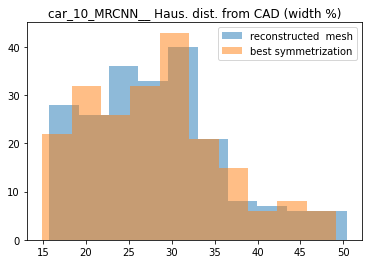

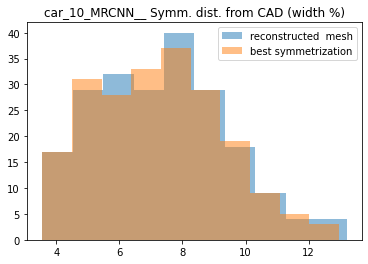

### data from ../save/plane_car_1_PointRend__/aeroplane-car-qualitative/cad_mesh_distances.npy 

Reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(41.74 %, 40.03 %), average improvement= 2.94 % 
  Symmetric dist =(12.74 %, 12.31 %), average improvement= 2.03 % 


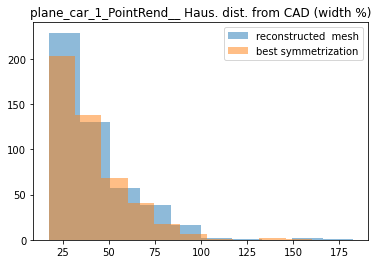

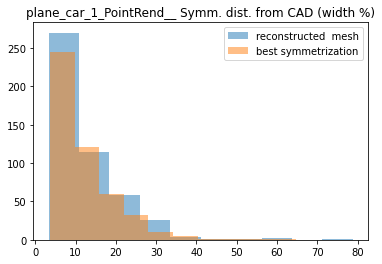

### data from ../save/plane_car_2_PointRend__/aeroplane-car-qualitative/cad_mesh_distances.npy 

Reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(28.18 %, 27.41 %), average improvement= 3.09 % 
  Symmetric dist =(7.77 %, 7.64 %), average improvement= 1.86 % 


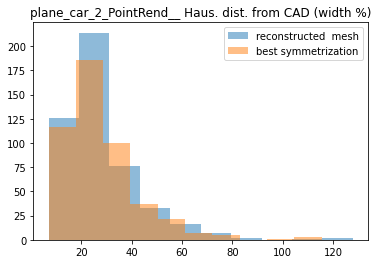

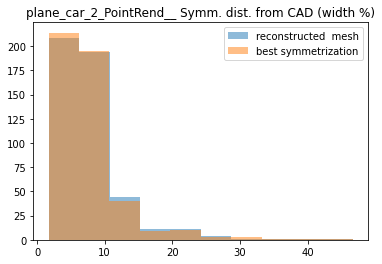

### data from ../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative/cad_mesh_distances.npy 

Reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(54.91 %, 53.60 %), average improvement= 1.90 % 
  Symmetric dist =(16.14 %, 15.90 %), average improvement= 1.90 % 


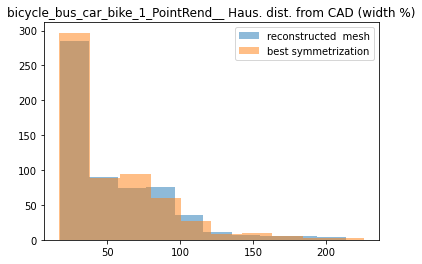

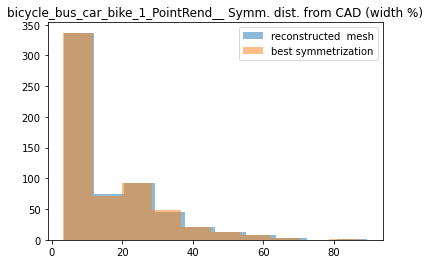

### data from ../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative/cad_mesh_distances.npy 

Reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(62.36 %, 60.94 %), average improvement= 1.84 % 
  Symmetric dist =(19.53 %, 19.25 %), average improvement= 1.45 % 


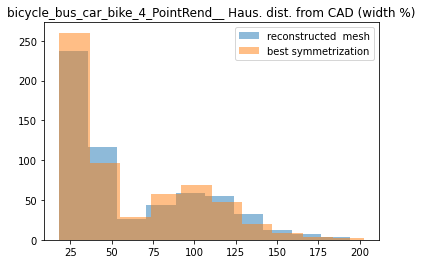

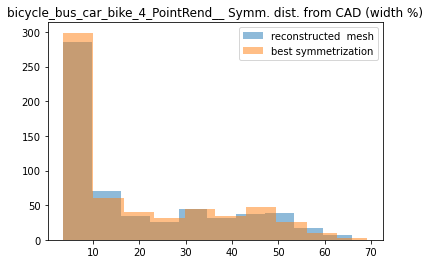

In [3]:
# data_path = '../save/car_10_MRCNN_small/car_small-qualitative'
for data_path in data_path_list:
       Out(f'data from {data_path}/cad_mesh_distances.npy ')
       #Out(f'Data from  {data_path}/shape_symmetries.npy  \n     {data_path}/cad_mesh_distances.npy ')

       #Fetching distance data 
       dist_data = np.load( data_path + '/cad_mesh_distances.npy', allow_pickle = True).item()
       mesh_to_cad_dist         = dist_data['mesh_to_cad_dist']
       LR_mesh_to_cad_dist      = dist_data['LR_mesh_to_cad_dist']
       RL_mesh_to_cad_dist      = dist_data['RL_mesh_to_cad_dist']
       best_reflection_dist     = dist_data['best_reflection_dist']
       improved_reflection_dist = dist_data['improved_reflection_dist']
       mesh_size                = dist_data['mesh_size']

       #improved_reflection_dist = improved_reflection_dist * mesh_size #values before normalization 
       #mean_improvemnt = improved_reflection_dist/mesh_to_cad_dist.mean()
       relative_improvemnt = improved_reflection_dist/mesh_to_cad_dist
       # metric 1 = max{mean(source-to-target dist.), mean(target-to-source dist) }, metric 2 =  max{  source-to-target dist. + target-to-source dist  }
       si =2 #metrics for symmetric distance 
        

       print( 'Reported average  CAD-to-mesh and best reflection distances:\n' + \
              f'  Hasdorff =({100*mesh_to_cad_dist[:,0].mean():.2f} %, {100*best_reflection_dist[:,0].mean():.2f} %)' + \
              f', average improvement= {100*relative_improvemnt[:,0].mean():.2f} % \n' + \
              f'  Symmetric dist #{si} =({100*mesh_to_cad_dist[:,si].mean():.2f} %, {100*best_reflection_dist[:,si].mean():.2f} %)' + \
              f', average improvement= {100*relative_improvemnt[:,si].mean():.2f} % ' )
       #test_name = os.path.split(data_path)[1]
       test_name = data_path.split('/')[-2]

       if multi_hist_layout: 
              plt.figure()
              plt.hist(100*mesh_to_cad_dist[:,0],      alpha=0.5, label='reconstructed  mesh')
              plt.hist(100*best_reflection_dist[:,0],  alpha=0.5, label='best symmetrization')
              plt.legend(loc='upper right')
              plt.title(test_name + ' Haus. dist. from CAD (width %)')
              plt.show()

              plt.figure()
              plt.hist(100*mesh_to_cad_dist[:,si],      alpha=0.5, label='reconstructed  mesh')
              plt.hist(100*best_reflection_dist[:,si],  alpha=0.5, label='best symmetrization')
              plt.legend(loc='upper right')
              plt.title(test_name + ' Symm. dist. from CAD (width %)')
              plt.show()


       else:
              f, ax = plt.subplots(1,2)
              ax[0].hist(100*mesh_to_cad_dist[:,0])
              ax[0].set_xlabel('CAD-to-Mesh')
              ax[0].set_ylabel('num of samples')
              f.suptitle(test_name + 'Haus. distances in width %')
              ax[1].hist(100*best_reflection_dist[:,0])
              ax[1].set_xlabel('CAD-to-Best reflection')
              ax[1].set_yticks([])

## Measure improvments of multi-class network for each class separately 

## Data from ../save/plane_car_1_PointRend__/aeroplane-car-qualitative/cad_mesh_distances.npy

##   Classes = car, aeroplane :

Class= car,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(29.93 %, 29.64 %), average improvement= 1.14 % 
  Symmetric dist =(7.91 %, 7.76 %), average improvement= 1.76 % 


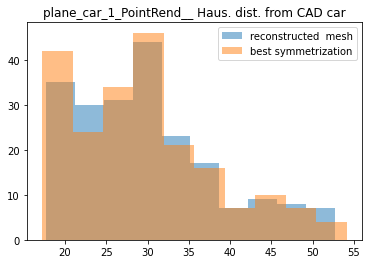

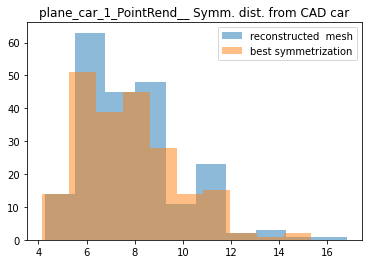

Class= aeroplane,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(51.10 %, 48.27 %), average improvement= 4.36 % 
  Symmetric dist =(16.58 %, 15.93 %), average improvement= 2.24 % 


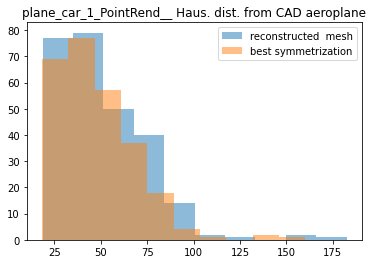

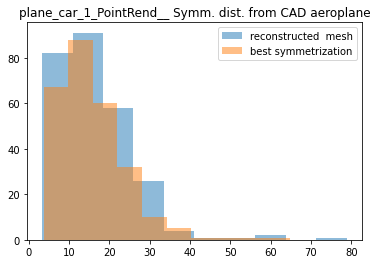

## Data from ../save/plane_car_2_PointRend__/aeroplane-car-qualitative/cad_mesh_distances.npy

##   Classes = car, aeroplane :

Class= car,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(30.23 %, 29.98 %), average improvement= 0.89 % 
  Symmetric dist =(7.87 %, 7.79 %), average improvement= 1.11 % 


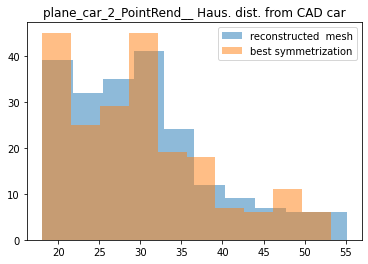

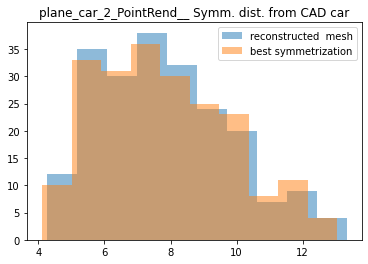

Class= aeroplane,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(26.56 %, 25.37 %), average improvement= 4.83 % 
  Symmetric dist =(7.69 %, 7.53 %), average improvement= 2.45 % 


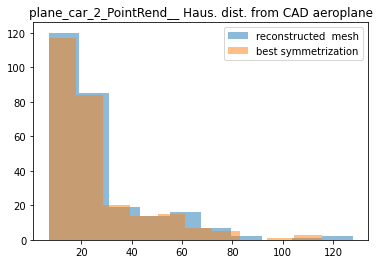

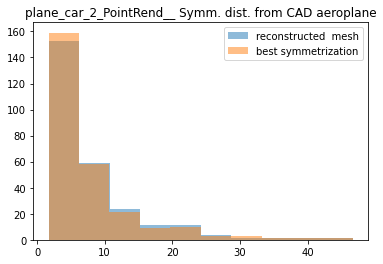

## Data from ../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative/cad_mesh_distances.npy

##   Classes = car, bus, bicycle, motorbike :

Class= car,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(30.26 %, 30.06 %), average improvement= 0.80 % 
  Symmetric dist =(8.09 %, 7.97 %), average improvement= 1.51 % 


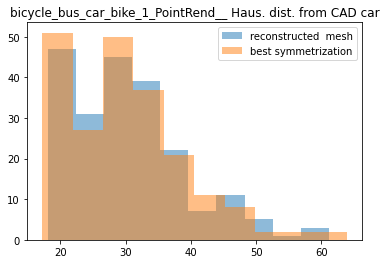

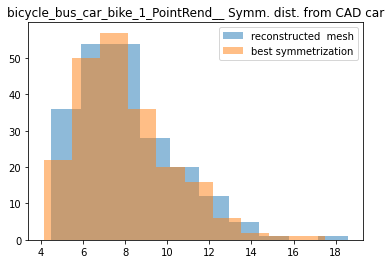

Class= bus,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(35.15 %, 34.45 %), average improvement= 1.91 % 
  Symmetric dist =(6.81 %, 6.58 %), average improvement= 3.40 % 


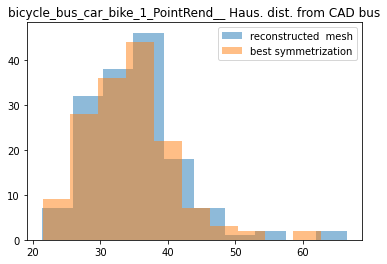

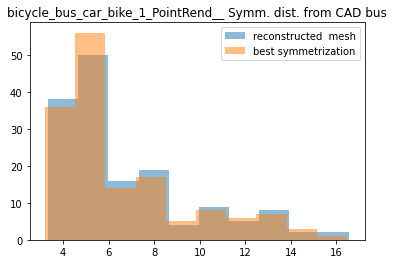

Class= bicycle,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(93.37 %, 90.12 %), average improvement= 3.55 % 
  Symmetric dist =(30.40 %, 29.91 %), average improvement= 1.79 % 


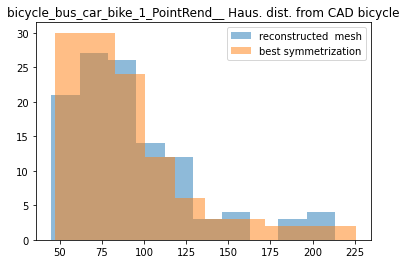

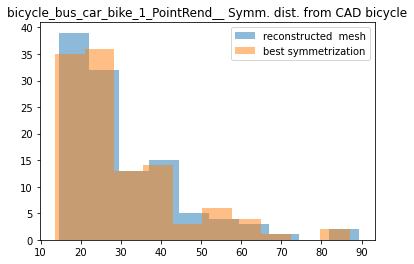

Class= motorbike,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(88.01 %, 85.80 %), average improvement= 2.28 % 
  Symmetric dist =(29.07 %, 28.85 %), average improvement= 0.73 % 


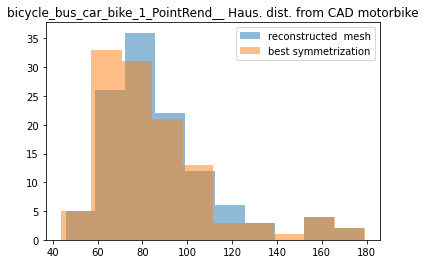

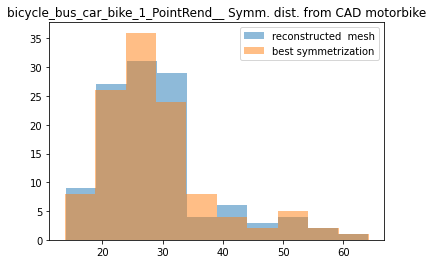

## Data from ../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative/cad_mesh_distances.npy

##   Classes = car, bus, bicycle, motorbike :

Class= car,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(31.64 %, 31.35 %), average improvement= 0.88 % 
  Symmetric dist =(8.36 %, 8.29 %), average improvement= 0.99 % 


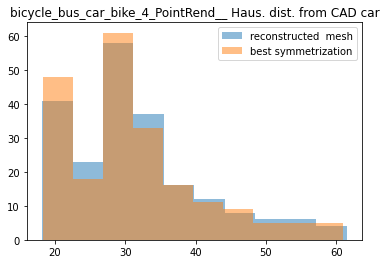

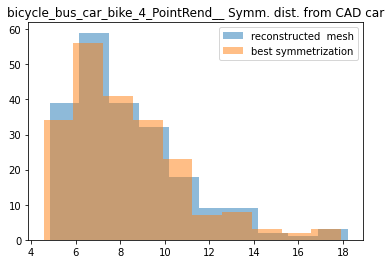

Class= bus,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(36.32 %, 35.30 %), average improvement= 2.71 % 
  Symmetric dist =(7.22 %, 7.07 %), average improvement= 2.13 % 


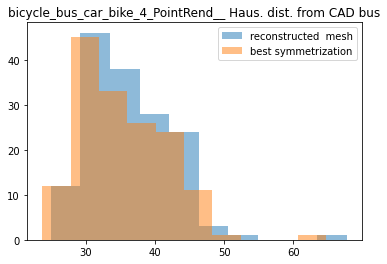

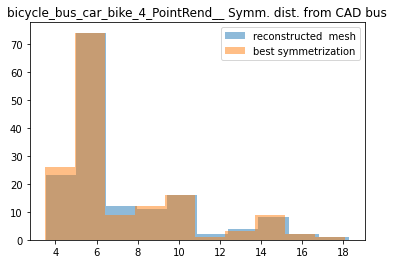

Class= bicycle,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(107.77 %, 105.27 %), average improvement= 1.93 % 
  Symmetric dist =(33.77 %, 33.20 %), average improvement= 1.72 % 


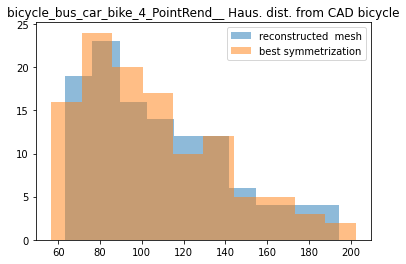

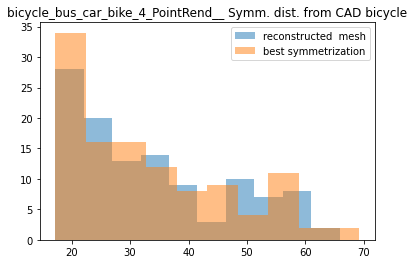

Class= motorbike,  reported average  CAD-to-mesh and best reflection distances:
  Hasdorff =(107.98 %, 105.04 %), average improvement= 2.33 % 
  Symmetric dist =(42.08 %, 41.56 %), average improvement= 1.13 % 


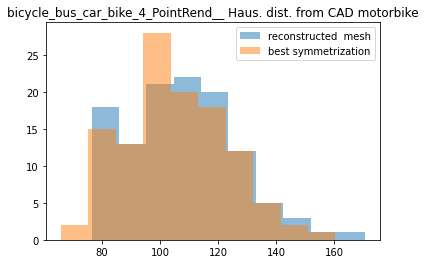

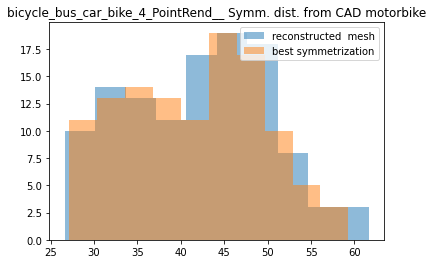

In [4]:
for data_path in data_path_list:
       bj_files,index_list, class_list, class_indices = get_obj_files(data_path) 
       dist_data = np.load( data_path + '/cad_mesh_distances.npy', allow_pickle = True).item()
       if len(class_indices.keys()) <= 1:
              continue 
       Out(f'Data from {data_path}/cad_mesh_distances.npy',2)
       Out(f'  Classes = {", ".join(class_indices.keys())} :',2)

       for obj_class, obj_indx in class_indices.items():
              mesh_to_cad_dist         = dist_data['mesh_to_cad_dist'][obj_indx]
              best_reflection_dist     = dist_data['best_reflection_dist'][obj_indx]
              improved_reflection_dist = dist_data['improved_reflection_dist'][obj_indx]
              mesh_size                = dist_data['mesh_size'][obj_indx]
              sample_num               = dist_data['mesh_to_cad_dist'][obj_indx].shape[0]

              relative_improvemnt = improved_reflection_dist/mesh_to_cad_dist
              print( f'Class= {obj_class},  reported average  CAD-to-mesh and best reflection distances:\n' + \
                     f'  Hasdorff =({100*mesh_to_cad_dist[:,0].mean():.2f} %, {100*best_reflection_dist[:,0].mean():.2f} %)' + \
                     f', average improvement= {100*relative_improvemnt[:,0].mean():.2f} % \n' + \
                     f'  Symmetric dist =({100*mesh_to_cad_dist[:,1].mean():.2f} %, {100*best_reflection_dist[:,1].mean():.2f} %)' + \
                     f', average improvement= {100*relative_improvemnt[:,1].mean():.2f} % ' )
              test_name = data_path.split('/')[-2]

              plt.figure()
              plt.hist(100*mesh_to_cad_dist[:,0],  alpha=0.5, label='reconstructed  mesh')
              plt.hist(100*best_reflection_dist[:,0],  alpha=0.5, label='best symmetrization')
              plt.legend(loc='upper right')
              plt.title(test_name + f' Haus. dist. from CAD {obj_class}')
              plt.show()

              plt.figure()
              plt.hist(100*mesh_to_cad_dist[:,1],  alpha=0.5, label='reconstructed  mesh')
              plt.hist(100*best_reflection_dist[:,1],  alpha=0.5, label='best symmetrization')
              plt.legend(loc='upper right')
              plt.title(test_name + f' Symm. dist. from CAD {obj_class}')
              plt.show()            

## Compute 3D distances between reconstructed meshes and GT CAD models for selected samples


In [ ]:
draw_step   = 1
sample_step = 10
# Check  save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative/cad_mesh_distances.txt
#Sample=0026: distances to mesh, its left-to-rigth and right-to-left reflections=  (1.2634, 2.1110, 2.0267), improvments= -0.7634
print('Sample=0026: distances to mesh, its left-to-rigth and right-to-left reflections=  (1.2634, 2.1110, 2.0267), improvments= -0.7634')
#for data_path in data_path_list:
for data_path in ['../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative']:
    #data_path = '../save/bicycle_bus_car_bike_4_PointRend_small/bicycle_small-bus_small-car_small-motorbike_small-qualitative'
    #class_name = os.path.split(data_path)[-1].split("-")[0]
    Out(f'Data from  {data_path}/shape_symmetries.npy')
    #fetching saved data 
    data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
    LR_max = data['LR_max']
    V_right = data['V_right']
    V_opposite = data['V_opposite']
    V_center   = np.nonzero(np.arange(0,V_opposite.shape[0]) == V_opposite)[0]
    V_left     = V_opposite[V_right]
    #H_symm = data['H_symm']
    
    class_and_type = os.path.split(data_path)[-1].split("-")[0].split("_")
    test_type_prefix = (class_and_type[1] if type(class_and_type) is list and len(class_and_type) > 1 else '')
    obj_file_glob = f'{data_path}/obj/*{test_type_prefix}_{"[0-9]"*4}.obj' 
    obj_pred_files = glob.glob(obj_file_glob)
    #Exclude weighted  mean shape obj files 
    wms_obj_files = glob.glob(f'{data_path}/obj/*_wms_{"[0-9]"*4}.obj')
    obj_pred_files  = list( set(obj_pred_files) - set(wms_obj_files) )

    #test_type = os.path.split(data_path)[-1].split("-")[0].split("_")[1]
    #obj_file_glob = f'{data_path}/obj/*_{test_type}_{"[0-9]"*4}.obj'
    #obj_pred_files = glob.glob(obj_file_glob)
    #num_of_samples = len(obj_pred_files)
    ####### 

    #for  i in range(0, num_of_samples, sample_step):
    #for  i in num_of_samples:
    for  i in [26]:
        obj_files =fnmatch.filter(obj_pred_files, f'{data_path}/obj/*{test_type_prefix}_{i:04}.obj')
        if (len(obj_files) > 1) or (not obj_files):
            print(f'Error: For sample {i} instead of a  single obj file, found the following files: {obj_files}')
            print(f'filter={data_path}/obj/*{test_type_prefix}_{i:04}.obj')
        obj_file = obj_files[0]
        class_name = os.path.split(obj_file)[-1].split("_")[0]

        is_visible = not (i % draw_step)

        #obj_file = f'{data_path}/obj/{class_name}_{i:04}.obj'
        Out(f'plot of mesh {obj_file}')

        ## loading CAD model of the sub-class
        V, F = igl.read_triangle_mesh(obj_file)
        V -= np.mean(V,axis=0) #align shape to 0,0,0  
        V_bbox    = V.max(0)- V.min(0)
        V_size = V_bbox[0] #longest dimension or width ?

        #visualize_symmetry_details(V,F,data)
        #break

        V_l2r =  np.copy(V)
        V_l2r -= np.mean(V_l2r,axis=0) #align shape to 0,0,0  
        V_l2r[V_right,:] = reflectX(V[V_opposite[V_right],:])
        V_l2r[V_center,0] =0
        V_l2r_bbox     = V_l2r.max(0)- V_l2r.min(0)


        cad_i = int(data['cad_idx'][i]) 
        short_class_name = class_name.split('_')[0]
        cad_file = f'{CAD_path}/{short_class_name}/{cad_i+1:02d}.off'
        Out(f'loading GT CAD from: {cad_file}')
        Vcad, Fcad = igl.read_triangle_mesh(cad_file)
        Vcad -=  np.mean(Vcad,axis=0) #align shape to 0,0,0  
        Vcad_bbox = Vcad.max(0)- Vcad.min(0)


        #mesh_draw_list =   [ [V,F,[0,0,1]],  [V_l2r,F,[0,1,0]],  [Vcad,Fcad,[1,1,0]] ]
        mesh_draw_list =   [  [Vcad,Fcad,[1,1,0]] ]

        if load_cad_from_mat:
            mat_file = f'{CAD_path}/{short_class_name}.mat'
            Out(f'loading GT CAD model num {cad_i} from: {mat_file}')
            mat_cad = scipy.io.loadmat(mat_file)
            mat_cad_i  = mat_cad['car'][0,cad_i] #in mat file cad index starts from 0, while off models start from 1
            Vcad_m = mat_cad_i['vertices']
            Vcad_m -= np.mean(Vcad_m,axis=0) #align shape to 0,0,0  
            Fcad_m = mat_cad_i['faces'] -1 #in mat file vertex indices start from 1 not 0 !
            #DrawMeshes(p, [ [Vcad_m,Fcad_m,[1,.8,.8]] ])
            mesh_draw_list.append( [Vcad_m,Fcad_m,[1,.8,.8]],   )

        
        if is_visible and draw_meshes_before_aligment:
            DrawMeshes(None, mesh_draw_list, shifts=(1.5,0,0))



        #aligning mesh to the CAD model of its sub-class
        Vs = np.copy(V)
        if enable_rescale_for_ICP:
            Vs = V * (Vcad_bbox/V_bbox)

        # With these configurtions its non-ditemenistic since its randomly samples 200 points.
        # Try to change samples/itertion and to swap between source and query points ...
        Rot, t = igl.iterative_closest_point(Vs,F,Vcad,Fcad,200,10) 
        Valigned = Vs @ Rot.transpose() + t 
        mesh2cad_haus_dist = igl.hausdorff(Valigned,F,Vcad,Fcad)/V_size
        mesh2cad_dist =  igl.point_mesh_squared_distance(Valigned,Vcad,Fcad)
        #print(mesh2cad_dist)
    
    


        V_l2r_icp,_,_  = gu.align_source2target_with_icp(V_l2r,F, Vcad,Fcad, 200,20)
        #V_l2r_icp,_,_  = gu.align_source2target_with_icp(Vcad,Fcad, V_l2r,F, 200,20)
        LR_mesh2cad_haus_dist = igl.hausdorff(V_l2r_icp,F, Vcad,Fcad)/V_size

        Out(f'{"rescaled" if enable_rescale_for_ICP else ""} \
            mesh-to-CAD  ICP, Hausdorff dist= {mesh2cad_haus_dist:.4f}')
        if is_visible:
            ph = mp.plot(np.zeros((1,3)))
            add_transparent_mesh(ph, Valigned, F,  c = color4plot([0,0,1],V), shading = shading_dic, opacity=0.7)
            add_transparent_mesh(ph, Vcad, Fcad,  c = color4plot([1,1,0],Vcad), shading = shading_dic, opacity=0.5)
        Out(f'{"rescaled" if enable_rescale_for_ICP else ""} \
            LR-reflection-to-CAD  ICP, Hausdorff dist= {LR_mesh2cad_haus_dist:.4f}')
        if is_visible:
            ph = mp.plot(np.zeros((1,3)))
            add_transparent_mesh(ph, V_l2r_icp, F,  c = color4plot([0,0,1],V), shading = shading_dic, opacity=0.7)
            add_transparent_mesh(ph, Vcad, Fcad,  c = color4plot([1,1,0],Vcad), shading = shading_dic, opacity=0.5)


